#####  Usaremos Vit-Large con épocas y un dataset que contiene masas benignas y malignas de VinDrMammo y DDSM combinados en png.

Resolving data files:   0%|          | 0/18128 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=224x224 at 0x12DC80D50>, 'label': 0}


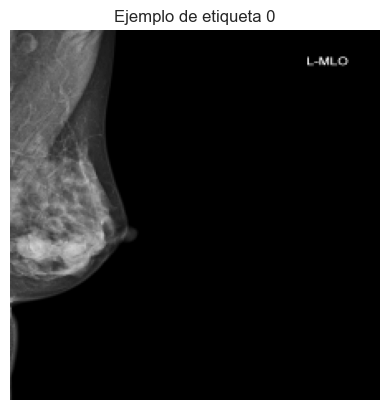

Casting the dataset:   0%|          | 0/18128 [00:00<?, ? examples/s]

ClassLabel(names=['Benign', 'Malignant'], id=None)
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=224x224 at 0x12EF8D890>, 'label': 0}


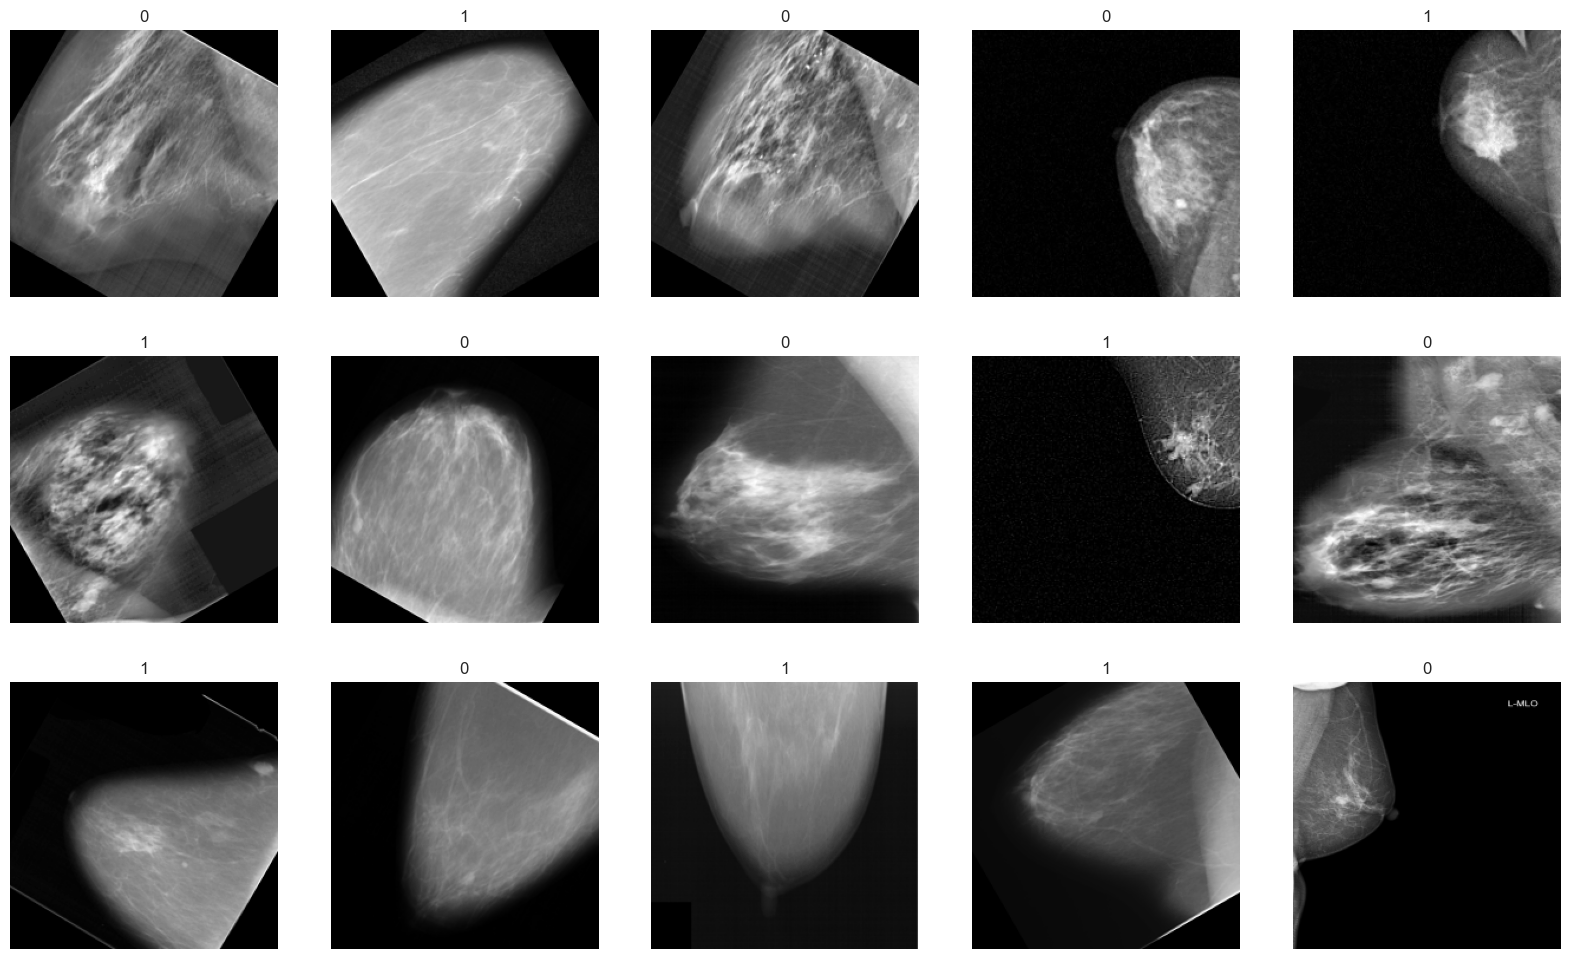

In [2]:
# =============================================================================
# Parte 1: Carga y Preprocesamiento de Datos
# =============================================================================

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import AutoImageProcessor

import evaluate  # Biblioteca para métricas de evaluación

# -----------------------------------------------------------------------------
# Carga del conjunto de datos
# -----------------------------------------------------------------------------

# Se carga el conjunto de datos desde la ruta especificada
dataset = load_dataset('/Volumes/m2/Memoria/Code/PMM/BeningMalignant_Masses-Preprocessing/data/processed/subset_datos/vinddsm/')
# Inspección del primer ejemplo del conjunto de entrenamiento
print(dataset['train'][0])

# -----------------------------------------------------------------------------
# Visualización de una imagen de ejemplo
# -----------------------------------------------------------------------------

# Obtener la imagen y mostrarla
im = dataset['train'][0]['image']
plt.imshow(im, cmap='gray')
plt.title('Ejemplo de etiqueta 0')
plt.axis('off')
plt.show()

# -----------------------------------------------------------------------------
# Mapeo de etiquetas numéricas a texto
# -----------------------------------------------------------------------------

# Definir el mapeo de etiquetas
label_map = {0: 'Benign', 1: 'Malignant'}

# Actualizar las características del conjunto de datos para incluir nombres de etiquetas
features = dataset['train'].features.copy()
features['label'] = ClassLabel(names=['Benign', 'Malignant'])

# Aplicar el mapeo al conjunto de datos
dataset = dataset.cast(features)

# Verificar las nuevas etiquetas
print(dataset['train'].features['label'])
print(dataset['train'][0])

# Crear diccionarios para mapeo entre etiquetas y IDs
labels = dataset['train'].unique('label')
label2id = {c: idx for idx, c in enumerate(labels)}
id2label = {idx: c for idx, c in enumerate(labels)}

# -----------------------------------------------------------------------------
# Visualización de muestras aleatorias
# -----------------------------------------------------------------------------

def show_samples(ds, rows, cols):
    """
    Muestra una cuadrícula de imágenes y etiquetas aleatorias del conjunto de datos.

    Args:
        ds (Dataset): Conjunto de datos de Hugging Face.
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    samples = ds.shuffle().select(np.arange(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

# Mostrar muestras del conjunto de entrenamiento
show_samples(dataset['train'], rows=3, cols=5)

# -----------------------------------------------------------------------------
# División del conjunto de datos en entrenamiento, validación y prueba
# -----------------------------------------------------------------------------

# Dividir el conjunto de entrenamiento en entrenamiento y prueba intermedia
split_dataset = dataset['train'].train_test_split(test_size=0.2)

# Dividir el conjunto de prueba intermedia en validación y prueba
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)

# Crear el conjunto de datos final con entrenamiento, validación y prueba
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

# -----------------------------------------------------------------------------
# Preprocesamiento de las imágenes
# -----------------------------------------------------------------------------

# Cargar el procesador de imágenes preentrenado
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224', use_fast=True)

def transforms(batch):
    """
    Aplica transformaciones a un batch de datos.

    Args:
        batch (dict): Batch de datos.

    Returns:
        dict: Batch transformado con 'pixel_values' y 'labels'.
    """
    # Convertir imágenes a RGB
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # Procesar imágenes
    inputs = processor(batch['image'], return_tensors='pt')
    # Mapear etiquetas de texto a IDs numéricos
    inputs['labels'] = [label2id[y] for y in batch['label']]
    return inputs

# Aplicar las transformaciones al conjunto de datos
processed_dataset = final_dataset.with_transform(transforms)

# -----------------------------------------------------------------------------
# Definición de la función de colación de datos
# -----------------------------------------------------------------------------

def collate_fn(batch):
    """
    Función personalizada para colacionar los datos en batches.

    Args:
        batch (list): Lista de ejemplos.

    Returns:
        dict: Batch colacionado con 'pixel_values' y 'labels' como tensores.
    """
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# -----------------------------------------------------------------------------
# Definición de la métrica de evaluación
# -----------------------------------------------------------------------------

# Cargar la métrica de precisión
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_preds):
    """
    Calcula las métricas de evaluación.

    Args:
        eval_preds (tuple): Tupla que contiene logits y etiquetas verdaderas.

    Returns:
        dict: Diccionario con la precisión calculada.
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score


In [3]:
# =============================================================================
# Parte 2: Configuración y Entrenamiento del Modelo con Correcciones
# =============================================================================

from transformers import ViTForImageClassification, Trainer, TrainingArguments
from transformers import TrainerCallback
from torch.utils.tensorboard import SummaryWriter
import torch

# -----------------------------------------------------------------------------
# Carga del modelo preentrenado
# -----------------------------------------------------------------------------

# Actualizar el modelo ViT preentrenado a la versión "large"
model = ViTForImageClassification.from_pretrained(
    'google/vit-large-patch16-224',
    num_labels=len(labels),
    ignore_mismatched_sizes=True
)

# -----------------------------------------------------------------------------
# Congelar todas las capas excepto el clasificador
# -----------------------------------------------------------------------------

for name, p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

# Mostrar el número total de parámetros y los entrenables
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

# -----------------------------------------------------------------------------
# Descongelar las últimas 5 capas del encoder para fine-tuning
# -----------------------------------------------------------------------------

# Obtener el número total de capas en el encoder
num_total_layers = len(list(model.vit.encoder.layer))  # Debería ser 24 para ViT-Large

# Definir el número de capas a descongelar
num_layers_to_unfreeze = 5

# Calcular el índice a partir del cual descongelar
unfreeze_from = num_total_layers - num_layers_to_unfreeze

# Iterar sobre todas las capas del encoder
for idx, layer in enumerate(model.vit.encoder.layer):
    if idx >= unfreeze_from:
        # Descongelar esta capa
        for param in layer.parameters():
            param.requires_grad = True
    else:
        # Congelar esta capa
        for param in layer.parameters():
            param.requires_grad = False

# Asegurarse de que el clasificador está descongelado
for param in model.classifier.parameters():
    param.requires_grad = True

# Mostrar el número total de parámetros y los entrenables después de descongelar
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Después de descongelar las últimas {num_layers_to_unfreeze} capas:")
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

# -----------------------------------------------------------------------------
# Detectar el dispositivo disponible
# -----------------------------------------------------------------------------

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Dispositivo utilizado para el entrenamiento: {device}")

# -----------------------------------------------------------------------------
# Configuración de los argumentos de entrenamiento con TensorBoard
# -----------------------------------------------------------------------------

training_args = TrainingArguments(
    output_dir="./VT_V8",
    per_device_train_batch_size=8,  # Reducido para acomodar el mayor uso de memoria
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-5,  # Posiblemente reducir la tasa de aprendizaje
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',  # Reportar a TensorBoard
    logging_dir='./VT_V8/runs',  # Directorio de logs para TensorBoard
    load_best_model_at_end=True,
    fp16=True if device == 'cuda' else False,  # Habilitar fp16 solo si CUDA está disponible
    # Eliminado 'torch_dtype' ya que no es un argumento válido
)

# Verificar la configuración de TrainingArguments
print(f"fp16 habilitado: {training_args.fp16}")

# -----------------------------------------------------------------------------
# Definición del Callback Personalizado para TensorBoard 
# -----------------------------------------------------------------------------

class CustomTensorBoardCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.writer = None

    def on_train_begin(self, args, state, control, **kwargs):
        if self.writer is None:
            # Inicializar el SummaryWriter de TensorBoard
            self.writer = SummaryWriter(log_dir=args.logging_dir)
            print(f"TensorBoard logs guardados en {args.logging_dir}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Este método se llama cada vez que el trainer registra logs.
        """
        if self.writer and logs is not None:
            for k, v in logs.items():
                if isinstance(v, (int, float)):
                    self.writer.add_scalar(k, v, state.global_step)

    def on_epoch_end(self, args, state, control, **kwargs):
        """
        Registrar imágenes y predicciones al final de cada época.
        """
        # Asegurarse de que state.epoch no es None y convertirlo a entero
        if state.epoch is not None:
            epoch_seed = int(state.epoch)
        else:
            epoch_seed = 0  # Valor por defecto si state.epoch es None

        # Seleccionar muestras aleatorias del conjunto de validación
        samples = final_dataset['validation'].shuffle(seed=epoch_seed).select(range(4))
        processed_samples = samples.with_transform(transforms)
        predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)

        for idx in range(len(samples)):
            img = samples[idx]['image']
            label_real = samples[idx]['label']
            label_pred = id2label[predictions[idx]]
            label = f"Real: {label_real}, Predicción: {label_pred}"
            img = img.convert('RGB')
            img_tensor = processor(images=img, return_tensors="pt")['pixel_values'][0].to(device)
            # Reescalar la imagen para visualización
            img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            # Añadir imagen al TensorBoard
            self.writer.add_image(f'Epoch_{epoch_seed}/Image_{idx}', img_np, dataformats='HWC')
            # Añadir texto con la etiqueta real y predicha
            self.writer.add_text(
                f'Epoch_{epoch_seed}/Prediction_{idx}',
                label,
                state.global_step
            )

    def on_train_end(self, args, state, control, **kwargs):
        if self.writer:
            self.writer.close()
            self.writer = None

# -----------------------------------------------------------------------------
# Inicialización del entrenador con el Callback de TensorBoard
# -----------------------------------------------------------------------------

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,         # Asegúrate de definir 'collate_fn'
    compute_metrics=compute_metrics,  # Asegúrate de definir 'compute_metrics'
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,              # Asegúrate de definir 'processor'
    callbacks=[CustomTensorBoardCallback()],  # Añadir el callback personalizado
)

# -----------------------------------------------------------------------------
# Verificación de la disponibilidad de MPS (para dispositivos Apple)
# -----------------------------------------------------------------------------

# Ya hemos detectado el dispositivo anteriormente
if device == 'mps':
    print("Usando dispositivo MPS para el entrenamiento.")
elif device == 'cuda':
    print("Usando dispositivo CUDA para el entrenamiento.")
else:
    print("Usando CPU para el entrenamiento.")

# -----------------------------------------------------------------------------
# Entrenamiento del modelo
# -----------------------------------------------------------------------------

trainer.train()

# Guardar el modelo entrenado
trainer.save_model()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total de parámetros: 303,303,682
Parámetros entrenables: 2,050
Después de descongelar las últimas 5 capas:
Total de parámetros: 303,303,682
Parámetros entrenables: 62,983,170
Dispositivo utilizado para el entrenamiento: mps
fp16 habilitado: False


/Volumes/m2/Memoria/Code/PMM/venv2/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Usando dispositivo MPS para el entrenamiento.
TensorBoard logs guardados en ./VT_V8/runs


Epoch,Training Loss,Validation Loss,Accuracy
1,0.122000,0.090542,0.961390
2,0.050300,0.078345,0.968560
3,0.011200,0.068650,0.972973
4,0.001100,0.077750,0.973525
5,0.000400,0.079208,0.973525


{'eval_loss': 0.0706763043999672, 'eval_accuracy': 0.97573083287369, 'eval_runtime': 682.6432, 'eval_samples_per_second': 2.656, 'eval_steps_per_second': 0.333, 'epoch': 5.0}


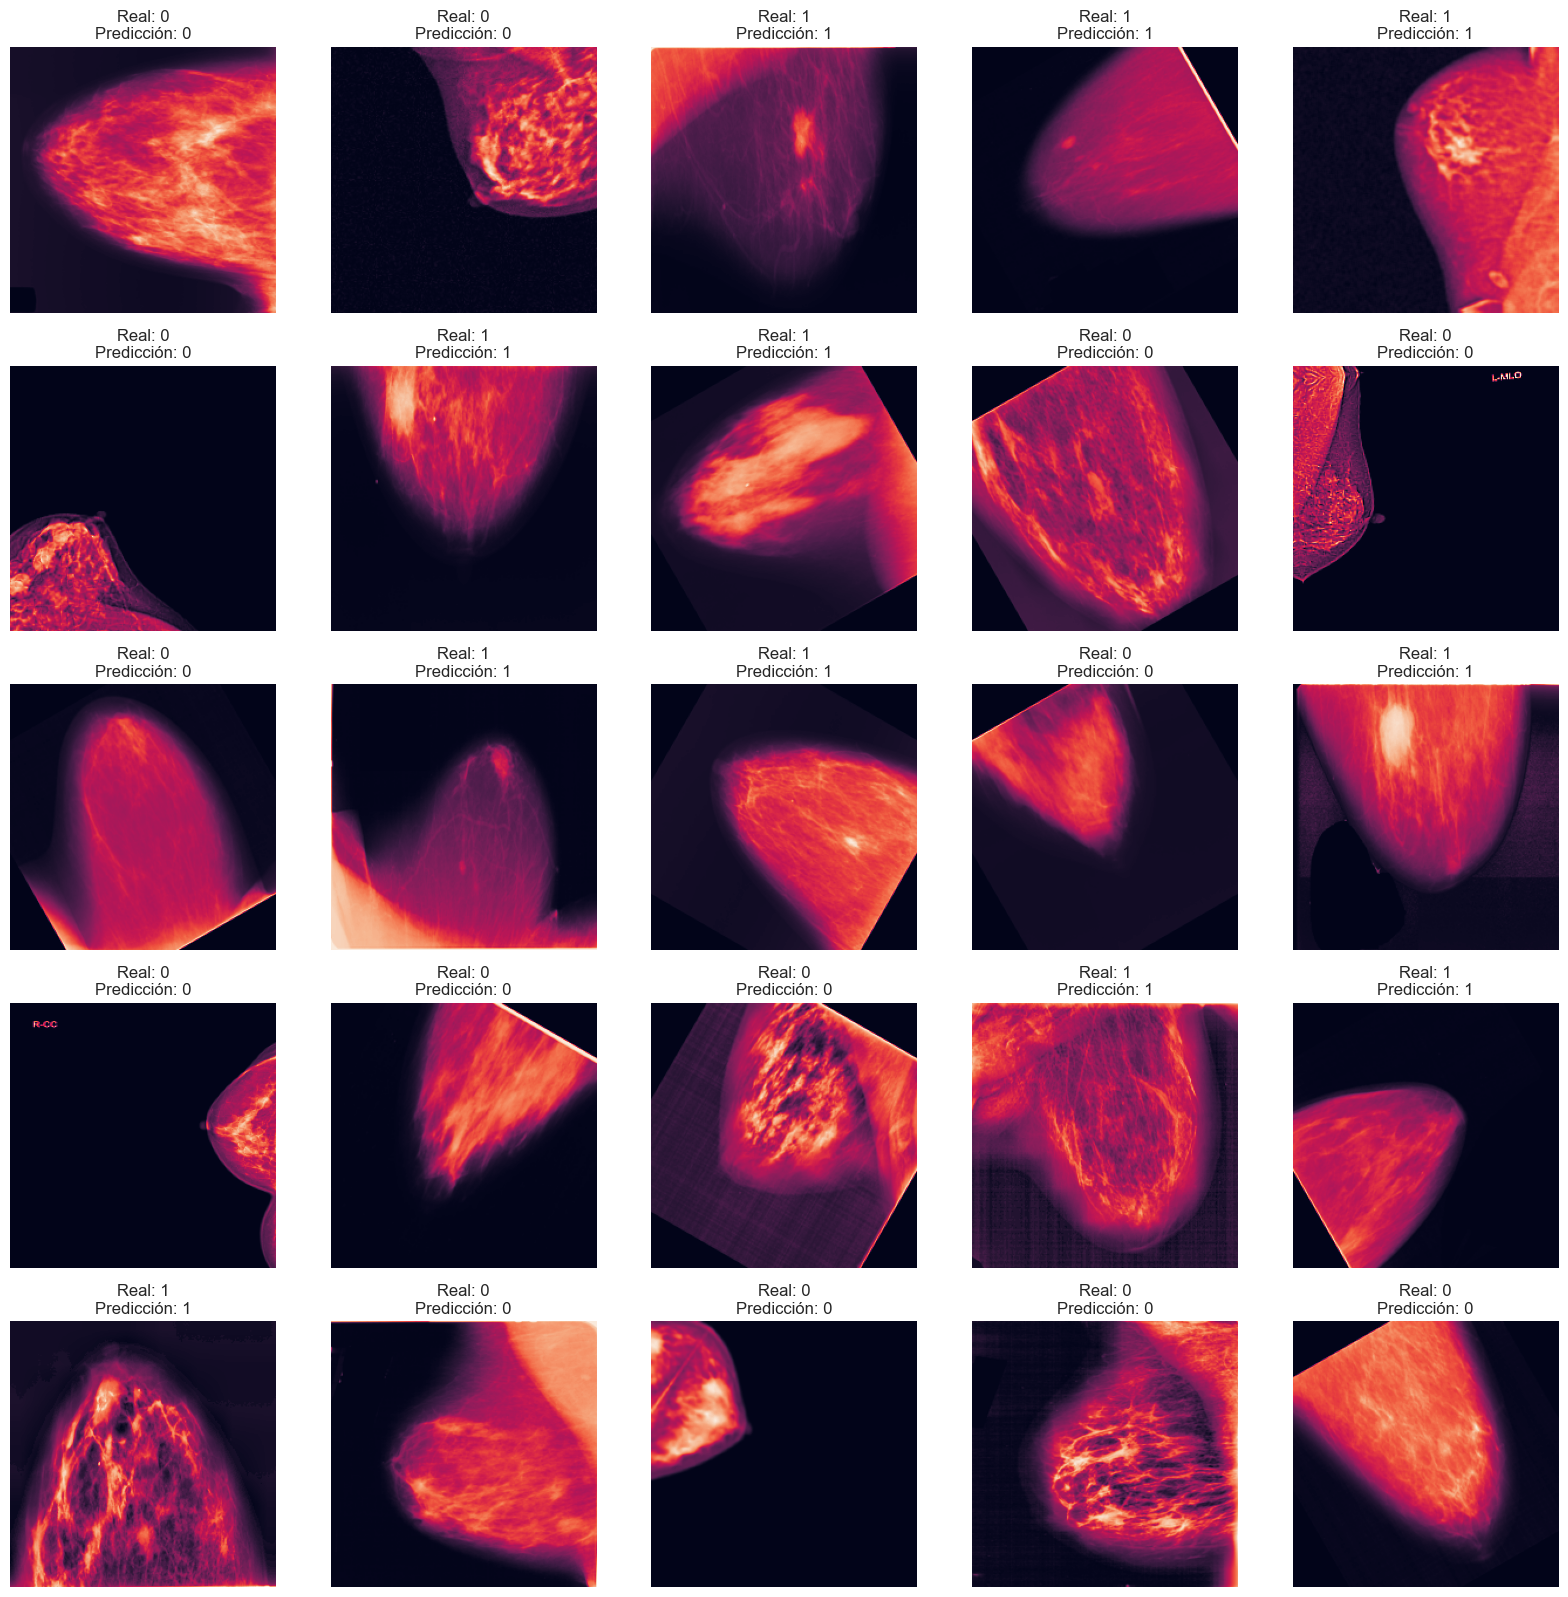

In [4]:
# =============================================================================
# Parte 3: Evaluación y Visualización de Resultados
# =============================================================================

# -----------------------------------------------------------------------------
# Evaluación del modelo en el conjunto de prueba
# -----------------------------------------------------------------------------

evaluation_results = trainer.evaluate(processed_dataset['test'])
print(evaluation_results)

# -----------------------------------------------------------------------------
# Función para mostrar predicciones
# -----------------------------------------------------------------------------

def show_predictions(rows, cols):
    """
    Muestra una cuadrícula de imágenes con sus etiquetas reales y predicciones.

    Args:
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    samples = final_dataset['test'].shuffle().select(np.arange(rows * cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label_real = samples[i]['label']
        label_pred = id2label[prediction]
        label = f"Real: {label_real}\nPredicción: {label_pred}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Mostrar predicciones en el conjunto de prueba
show_predictions(rows=5, cols=5)
